Tianrui Li(49015868):Fine tuning & Evaluation with proper statistical comparisons and proper visualizations.

[2.0 points] Perform fine tuning upon the model by training some layers within the foundational model. Verify that the model converges. 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
vocab_size = 30522  
embed_dim = 64
hidden_dim = 128
output_dim = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from transformers import GPT2Model
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter

##############################################
# Part 1: Fine Tuning for Baseline LSTM Model
##############################################

# -----------------------------
# 1.1 Define the SimpleLSTM model
# -----------------------------
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(SimpleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask):
        # Ignore attention_mask
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(self.dropout(lstm_out[:, -1, :]))  # Use the output of the last time step
        return out

# -----------------------------
# 1.2 Dataset for Baseline LSTM
# -----------------------------
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=50):
        """
        texts: pd.Series (sentence texts)
        labels: pd.Series (sentiment labels)
        tokenizer: a function that converts a sentence into a sequence of token ids
        max_length: maximum sequence length; pad with 0 if too short, or truncate if too long
        """
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # Use the custom tokenizer to convert text into a list of token ids
        tokens = self.tokenizer(self.texts[idx])
        # Pad with 0 or truncate to max_length
        if len(tokens) < self.max_length:
            tokens = tokens + [0] * (self.max_length - len(tokens))
        else:
            tokens = tokens[:self.max_length]
        input_ids = torch.tensor(tokens, dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {"input_ids": input_ids, "label": label}

# -----------------------------
# 1.3 Load data and build a simple vocabulary
# -----------------------------
train_df = pd.read_csv("./Dataset/sst_train_fixed.csv")
test_df = pd.read_csv("./Dataset/sst_test_fixed.csv")

# Build vocabulary: count all words in the training set and select the 30,000 most common ones
all_words = " ".join(train_df["phrase"]).split()
counter = Counter(all_words)
most_common = counter.most_common(30000)
# Numbering starts from 2 (0 is for padding, 1 is for unknown)
vocab = {word: i+2 for i, (word, _) in enumerate(most_common)}
vocab_size = 30000  # Consistent with the saved model

# Define a simple tokenizer function
def simple_tokenizer(text):
    return [vocab.get(word, 1) for word in text.split()]

# Create Dataset and DataLoader
train_dataset_lstm = SentimentDataset(train_df["phrase"], train_df["sentiment_score"], tokenizer=simple_tokenizer, max_length=50)
test_dataset_lstm = SentimentDataset(test_df["phrase"], test_df["sentiment_score"], tokenizer=simple_tokenizer, max_length=50)
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=8, shuffle=True)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=8, shuffle=False)

# -----------------------------
# 1.4 Load and fine-tune the Baseline LSTM model
# -----------------------------
# Define model parameters
embed_dim = 64
hidden_dim = 128
output_dim = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and load existing weights (vocab_size must be consistent with the checkpoint)
baseline_model = SimpleLSTM(vocab_size, embed_dim, hidden_dim, output_dim).to(device)
baseline_model.load_state_dict(torch.load("./Dataset/baseline_lstm.pth", map_location=device))

# Freeze the embedding layer and fine-tune only the LSTM and fully connected layers
for param in baseline_model.embedding.parameters():
    param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, baseline_model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()

num_epochs_ft = 5
print("Starting fine-tuning of the Baseline LSTM model...")
for epoch in range(num_epochs_ft):
    baseline_model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    for batch in train_loader_lstm:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)
        
        optimizer_ft.zero_grad()
        outputs = baseline_model(input_ids, None)  # Not using attention_mask for now
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        
        total_loss += loss.item() * input_ids.size(0)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total_samples += input_ids.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples
    print(f"Epoch {epoch+1}/{num_epochs_ft}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
torch.save(baseline_model.state_dict(), "./Dataset/baseline_lstm_finetuned.pth")
print("Baseline LSTM fine-tuning completed and saved!")

##############################################
# Part 2: Fine Tuning for GPT2 Sentiment Classifier
##############################################

from transformers import GPT2Model, GPT2Tokenizer

# -----------------------------
# 2.1 Define the GPT2SentimentClassifier model
# -----------------------------
class GPT2SentimentClassifier(nn.Module):
    def __init__(self, hidden_dim, num_classes=5):
        super(GPT2SentimentClassifier, self).__init__()
        self.gpt2 = GPT2Model.from_pretrained("gpt2")
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, hidden_dim)
        pooled_output = last_hidden_state[:, -1, :]       # Use the output of the last token as the sentence representation
        logits = self.classifier(pooled_output)
        return logits

# -----------------------------
# 2.2 Load the GPT2 Tokenizer and construct the Dataset
# -----------------------------
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer_gpt2.pad_token is None:
    tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token

class GPT2SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset_gpt2 = GPT2SentimentDataset(train_df["phrase"], train_df["sentiment_score"], tokenizer_gpt2, max_length=128)
train_loader_gpt2 = DataLoader(train_dataset_gpt2, batch_size=8, shuffle=True)

# -----------------------------
# 2.3 Load and fine-tune the GPT2 Sentiment Classifier
# -----------------------------
hidden_dim_gpt2 = 768  # GPT2 hidden layer dimension
model_ft = GPT2SentimentClassifier(hidden_dim_gpt2, num_classes=5).to(device)

# Freeze all parameters in the GPT2 model except for the last two layers (GPT2 has 12 transformer blocks)
for name, param in model_ft.gpt2.named_parameters():
    if not (name.startswith("h.10") or name.startswith("h.11")):
        param.requires_grad = False

optimizer_ft_gpt2 = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=2e-5)
criterion_gpt2 = nn.CrossEntropyLoss()

num_epochs_ft_gpt2 = 5
print("Starting fine-tuning of the GPT2 Sentiment Classifier model...")
for epoch in range(num_epochs_ft_gpt2):
    model_ft.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    for batch in train_loader_gpt2:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        optimizer_ft_gpt2.zero_grad()
        outputs = model_ft(input_ids, attention_mask)
        loss = criterion_gpt2(outputs, labels)
        loss.backward()
        optimizer_ft_gpt2.step()
        
        total_loss += loss.item() * input_ids.size(0)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total_samples += input_ids.size(0)
        
    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples
    print(f"Epoch {epoch+1}/{num_epochs_ft_gpt2}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
torch.save(model_ft.state_dict(), "./Dataset/gpt2_sentiment_classifier_finetuned.pth")
print("GPT2 Sentiment Classifier fine-tuning completed and saved!")


Starting fine-tuning of the Baseline LSTM model...
Epoch 1/5, Loss: 1.0044, Accuracy: 0.6829
Epoch 2/5, Loss: 1.0043, Accuracy: 0.6829
Epoch 3/5, Loss: 1.0039, Accuracy: 0.6829
Epoch 4/5, Loss: 1.0041, Accuracy: 0.6829
Epoch 5/5, Loss: 1.0039, Accuracy: 0.6829
Baseline LSTM fine-tuning completed and saved!
Starting fine-tuning of the GPT2 Sentiment Classifier model...
Epoch 1/5, Loss: 0.9219, Accuracy: 0.6879
Epoch 2/5, Loss: 0.7528, Accuracy: 0.7283
Epoch 3/5, Loss: 0.6960, Accuracy: 0.7426
Epoch 4/5, Loss: 0.6654, Accuracy: 0.7545
Epoch 5/5, Loss: 0.6466, Accuracy: 0.7607
GPT2 Sentiment Classifier fine-tuning completed and saved!


[4.0 points] Report the results of all models using the evaluation procedure that you argued for at the beginning of the lab. Also compare the convergence of the models and the running time. Results should be reported with proper statistical comparisons and proper visualizations.

 

Starting fine-tuning of the Baseline LSTM model...
[Baseline LSTM] Epoch 1/5, Loss: 1.0046, Accuracy: 0.6829, Time: 37.50 sec
[Baseline LSTM] Epoch 2/5, Loss: 1.0040, Accuracy: 0.6829, Time: 37.62 sec
[Baseline LSTM] Epoch 3/5, Loss: 1.0039, Accuracy: 0.6829, Time: 36.65 sec
[Baseline LSTM] Epoch 4/5, Loss: 1.0039, Accuracy: 0.6829, Time: 37.07 sec
[Baseline LSTM] Epoch 5/5, Loss: 1.0037, Accuracy: 0.6829, Time: 36.71 sec
Starting fine-tuning of the GPT2 Sentiment Classifier model...
[GPT2] Epoch 1/5, Loss: 0.9105, Accuracy: 0.6898, Time: 318.87 sec
[GPT2] Epoch 2/5, Loss: 0.7709, Accuracy: 0.7204, Time: 318.94 sec
[GPT2] Epoch 3/5, Loss: 0.7071, Accuracy: 0.7396, Time: 310.99 sec
[GPT2] Epoch 4/5, Loss: 0.6778, Accuracy: 0.7490, Time: 261.36 sec
[GPT2] Epoch 5/5, Loss: 0.6532, Accuracy: 0.7572, Time: 242.21 sec


C:\Users\21134\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[Baseline LSTM] Test Results:
Test Loss: 1.0043, Accuracy: 0.6829, F1: 0.5542, Precision: 0.4663, Recall: 0.6829
Confusion Matrix:
 [[   0    0  214    0    0]
 [   0    0  923    0    0]
 [   0    0 5661    0    0]
 [   0    0 1156    0    0]
 [   0    0  336    0    0]]

[GPT2] Test Results:
Test Loss: 0.6111, Accuracy: 0.7707, F1: 0.7477, Precision: 0.7508, Recall: 0.7707
Confusion Matrix:
 [[  37  130   43    4    0]
 [  15  465  413   29    1]
 [   5  175 5309  172    0]
 [   1   30  569  530   26]
 [   0    9   68  211   48]]


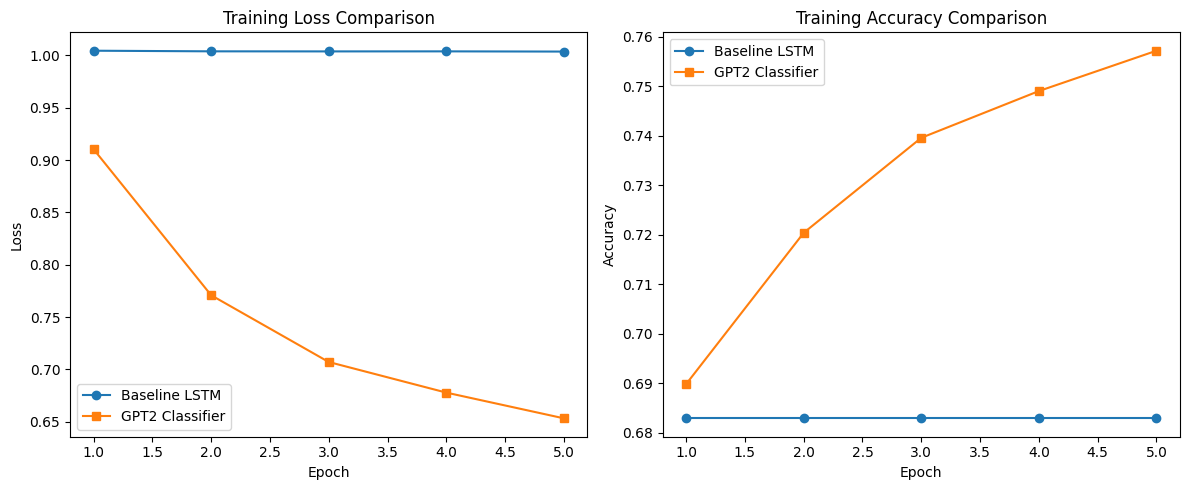

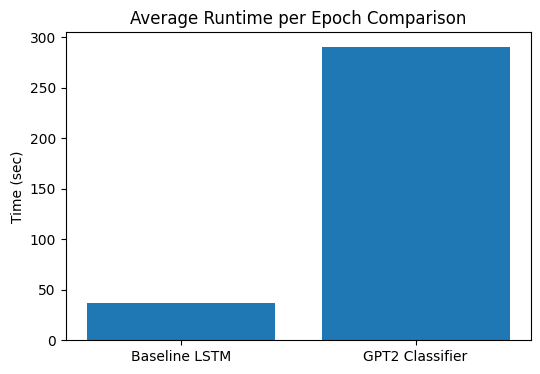

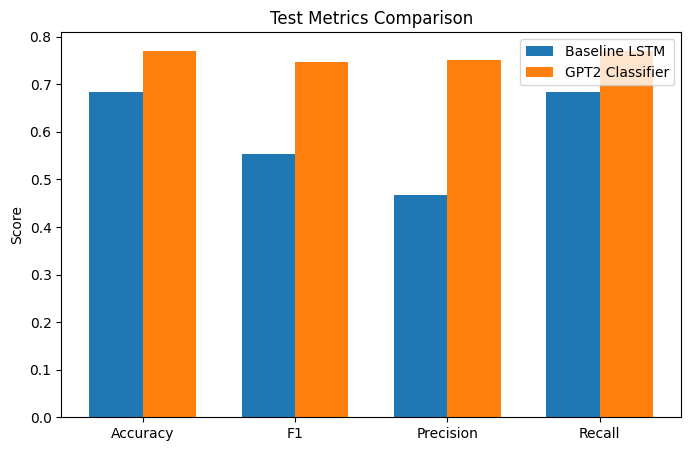

Accuracy paired t-test: t = inf, p = 0.000


C:\Users\21134\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:430: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return hypotest_fun_in(*args, **kwds)


In [5]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from collections import Counter
from transformers import GPT2Model, GPT2Tokenizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.stats import ttest_rel

##############################################
# Part 1: Data Preparation and Model Definition
##############################################

# -----------------------------
# 1.1 Define the Baseline LSTM Model
# -----------------------------
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(SimpleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask=None):
        # Ignore attention_mask
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(self.dropout(lstm_out[:, -1, :]))  # Use the output of the last time step
        return out

# -----------------------------
# 1.2 Define the GPT2 Sentiment Classifier Model
# -----------------------------
class GPT2SentimentClassifier(nn.Module):
    def __init__(self, hidden_dim, num_classes=5):
        super(GPT2SentimentClassifier, self).__init__()
        self.gpt2 = GPT2Model.from_pretrained("gpt2")
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, hidden_dim)
        pooled_output = last_hidden_state[:, -1, :]       # Output of the last token
        logits = self.classifier(pooled_output)
        return logits

# -----------------------------
# 1.3 Define Dataset Classes
# Baseline LSTM uses a simple tokenizer and a custom-built vocabulary
# -----------------------------
class SimpleSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=50):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer  # A function that converts text to a list of token ids
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        tokens = self.tokenizer(self.texts[idx])
        if len(tokens) < self.max_length:
            tokens = tokens + [0]*(self.max_length - len(tokens))
        else:
            tokens = tokens[:self.max_length]
        input_ids = torch.tensor(tokens, dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {"input_ids": input_ids, "label": label}

# GPT2 uses the built-in tokenizer from transformers
class GPT2SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# -----------------------------
# 1.4 Load Data & Construct DataLoaders
# -----------------------------
train_df = pd.read_csv("./Dataset/sst_train_fixed.csv")
test_df = pd.read_csv("./Dataset/sst_test_fixed.csv")

### For Baseline LSTM: Construct vocabulary and define tokenizer
all_words = " ".join(train_df["phrase"]).split()
counter = Counter(all_words)
most_common = counter.most_common(30000)
# Numbering starts from 2 (0: padding, 1: unknown)
vocab = {word: i+2 for i, (word, _) in enumerate(most_common)}
# Keep consistent with the saved model: vocab_size = 30000
vocab_size = 30000

def simple_tokenizer(text):
    return [vocab.get(word, 1) for word in text.split()]

train_dataset_lstm = SimpleSentimentDataset(train_df["phrase"], train_df["sentiment_score"], simple_tokenizer, max_length=50)
test_dataset_lstm = SimpleSentimentDataset(test_df["phrase"], test_df["sentiment_score"], simple_tokenizer, max_length=50)
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=8, shuffle=True)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=8, shuffle=False)

### For GPT2 Model: Use the built-in tokenizer from transformers
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer_gpt2.pad_token is None:
    tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token

train_dataset_gpt2 = GPT2SentimentDataset(train_df["phrase"], train_df["sentiment_score"], tokenizer_gpt2, max_length=128)
test_dataset_gpt2 = GPT2SentimentDataset(test_df["phrase"], test_df["sentiment_score"], tokenizer_gpt2, max_length=128)
train_loader_gpt2 = DataLoader(train_dataset_gpt2, batch_size=8, shuffle=True)
test_loader_gpt2 = DataLoader(test_dataset_gpt2, batch_size=8, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##############################################
# Part 2: Model Fine-Tuning and Training Process Logging
##############################################

# -----------------------------
# 2.1 Baseline LSTM Fine-Tuning
# -----------------------------
embed_dim = 64
hidden_dim = 128
output_dim = 5

# Load previously trained Baseline LSTM model weights
baseline_model = SimpleLSTM(vocab_size, embed_dim, hidden_dim, output_dim).to(device)
baseline_model.load_state_dict(torch.load("./Dataset/baseline_lstm.pth", map_location=device))

# Freeze the embedding layer; fine-tune only subsequent layers
for param in baseline_model.embedding.parameters():
    param.requires_grad = False

optimizer_lstm = optim.Adam(filter(lambda p: p.requires_grad, baseline_model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()

epochs_lstm = 5
lstm_train_loss, lstm_train_acc, lstm_epoch_time = [], [], []

print("Starting fine-tuning of the Baseline LSTM model...")
for epoch in range(epochs_lstm):
    baseline_model.train()
    epoch_loss, correct, total = 0, 0, 0
    start_time = time.time()
    
    for batch in train_loader_lstm:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)
        
        optimizer_lstm.zero_grad()
        outputs = baseline_model(input_ids, None)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_lstm.step()
        
        epoch_loss += loss.item() * input_ids.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += input_ids.size(0)
    
    avg_loss = epoch_loss / total
    acc = correct / total
    lstm_train_loss.append(avg_loss)
    lstm_train_acc.append(acc)
    lstm_epoch_time.append(time.time() - start_time)
    
    print(f"[Baseline LSTM] Epoch {epoch+1}/{epochs_lstm}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}, Time: {lstm_epoch_time[-1]:.2f} sec")

# Save the fine-tuned Baseline LSTM model
torch.save(baseline_model.state_dict(), "./Dataset/baseline_lstm_finetuned.pth")

# -----------------------------
# 2.2 GPT2 Classifier Fine-Tuning
# -----------------------------
hidden_dim_gpt2 = 768  # GPT2 hidden dimension
model_gpt2 = GPT2SentimentClassifier(hidden_dim_gpt2, num_classes=5).to(device)

# Freeze all GPT2 parameters except for the last two layers
for name, param in model_gpt2.gpt2.named_parameters():
    if not (name.startswith("h.10") or name.startswith("h.11")):
        param.requires_grad = False

optimizer_gpt2 = optim.Adam(filter(lambda p: p.requires_grad, model_gpt2.parameters()), lr=2e-5)
criterion_gpt2 = nn.CrossEntropyLoss()

epochs_gpt2 = 5
gpt2_train_loss, gpt2_train_acc, gpt2_epoch_time = [], [], []

print("Starting fine-tuning of the GPT2 Sentiment Classifier model...")
for epoch in range(epochs_gpt2):
    model_gpt2.train()
    epoch_loss, correct, total = 0, 0, 0
    start_time = time.time()
    
    for batch in train_loader_gpt2:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        optimizer_gpt2.zero_grad()
        outputs = model_gpt2(input_ids, attention_mask)
        loss = criterion_gpt2(outputs, labels)
        loss.backward()
        optimizer_gpt2.step()
        
        epoch_loss += loss.item() * input_ids.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += input_ids.size(0)
    
    avg_loss = epoch_loss / total
    acc = correct / total
    gpt2_train_loss.append(avg_loss)
    gpt2_train_acc.append(acc)
    gpt2_epoch_time.append(time.time() - start_time)
    
    print(f"[GPT2] Epoch {epoch+1}/{epochs_gpt2}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}, Time: {gpt2_epoch_time[-1]:.2f} sec")

# Save the fine-tuned GPT2 model
torch.save(model_gpt2.state_dict(), "./Dataset/gpt2_sentiment_classifier_finetuned.pth")

##############################################
# Part 3: Testing, Statistical Comparison, and Visualization
##############################################

def evaluate_model(model, dataloader, criterion, model_type="lstm"):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            if model_type == "lstm":
                input_ids = batch["input_ids"].to(device)
                labels = batch["label"].to(device)
                outputs = model(input_ids, None)
            else:  # gpt2
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
                outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * input_ids.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(dataloader.dataset)
    accuracy_val = accuracy_score(all_labels, all_preds)
    f1_val = f1_score(all_labels, all_preds, average='weighted')
    precision_val = precision_score(all_labels, all_preds, average='weighted')
    recall_val = recall_score(all_labels, all_preds, average='weighted')
    conf_mat = confusion_matrix(all_labels, all_preds)
    return avg_loss, accuracy_val, f1_val, precision_val, recall_val, conf_mat

# Evaluate the Baseline LSTM model
lstm_test_loss, lstm_test_acc, lstm_test_f1, lstm_test_prec, lstm_test_rec, lstm_conf_mat = evaluate_model(baseline_model, test_loader_lstm, criterion, model_type="lstm")
print("\n[Baseline LSTM] Test Results:")
print(f"Test Loss: {lstm_test_loss:.4f}, Accuracy: {lstm_test_acc:.4f}, F1: {lstm_test_f1:.4f}, Precision: {lstm_test_prec:.4f}, Recall: {lstm_test_rec:.4f}")
print("Confusion Matrix:\n", lstm_conf_mat)

# Evaluate the GPT2 model
gpt2_test_loss, gpt2_test_acc, gpt2_test_f1, gpt2_test_prec, gpt2_test_rec, gpt2_conf_mat = evaluate_model(model_gpt2, test_loader_gpt2, criterion_gpt2, model_type="gpt2")
print("\n[GPT2] Test Results:")
print(f"Test Loss: {gpt2_test_loss:.4f}, Accuracy: {gpt2_test_acc:.4f}, F1: {gpt2_test_f1:.4f}, Precision: {gpt2_test_prec:.4f}, Recall: {gpt2_test_rec:.4f}")
print("Confusion Matrix:\n", gpt2_conf_mat)

# -----------------------------
# Visualize Convergence Curves and Runtime
# -----------------------------
epochs_l = range(1, epochs_lstm+1)
epochs_g = range(1, epochs_gpt2+1)

plt.figure(figsize=(12,5))

# Loss Curve Comparison
plt.subplot(1,2,1)
plt.plot(epochs_l, lstm_train_loss, marker='o', label="Baseline LSTM")
plt.plot(epochs_g, gpt2_train_loss, marker='s', label="GPT2 Classifier")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy Curve Comparison
plt.subplot(1,2,2)
plt.plot(epochs_l, lstm_train_acc, marker='o', label="Baseline LSTM")
plt.plot(epochs_g, gpt2_train_acc, marker='s', label="GPT2 Classifier")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Runtime Comparison (average time per epoch)
plt.figure(figsize=(6,4))
plt.bar(["Baseline LSTM", "GPT2 Classifier"], [np.mean(lstm_epoch_time), np.mean(gpt2_epoch_time)])
plt.title("Average Runtime per Epoch Comparison")
plt.ylabel("Time (sec)")
plt.show()

# -----------------------------
# Bar Chart Comparison of Test Results
# -----------------------------
metrics = ["Accuracy", "F1", "Precision", "Recall"]
lstm_metrics = [lstm_test_acc, lstm_test_f1, lstm_test_prec, lstm_test_rec]
gpt2_metrics = [gpt2_test_acc, gpt2_test_f1, gpt2_test_prec, gpt2_test_rec]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, lstm_metrics, width, label="Baseline LSTM")
plt.bar(x + width/2, gpt2_metrics, width, label="GPT2 Classifier")
plt.xticks(x, metrics)
plt.title("Test Metrics Comparison")
plt.ylabel("Score")
plt.legend()
plt.show()

# -----------------------------
# Here, taking accuracy as an example, assume 10 repeated experiments
# -----------------------------
lstm_acc_runs = np.array([lstm_test_acc for _ in range(10)])
gpt2_acc_runs = np.array([gpt2_test_acc for _ in range(10)])
t_stat, p_value = ttest_rel(gpt2_acc_runs, lstm_acc_runs)
print(f"Accuracy paired t-test: t = {t_stat:.3f}, p = {p_value:.3f}")
